# Creating A XGBOOST MODEL 


## Loading and Cleaning the Data
first of all we will load our datasets and clean them.

In [103]:
# Loading Packages
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import seaborn as sns



In [104]:
# Loading the data 1- features 
att_v2 = pd.read_excel("FVIII_attributes_v2.xlsx", sheet_name = "FVIII_attributes")
att_v2.head()

,AA_HGVS,Residue,Domain,relSESA,consurf_old,dg,bt,cl,auth,kcore
0,20,A,A1,1.039415,-0.438,2,0.000000,0.111791,0.018996,2
1,21,T,A1,0.801030,-0.496,3,0.000000,0.113146,0.040660,3
2,22,R,A1,0.499384,-0.784,10,0.005384,0.119778,0.105625,5
3,23,R,A1,0.822534,0.278,3,0.000731,0.111507,0.034230,2
4,24,Y,A1,0.371264,0.087,10,0.003627,0.121302,0.156471,5


In [105]:
patients_data = pd.read_excel("FVIII_discrepant_mutations.xlsx", sheet_name = "Unique_mutations")
patients_data.head()


,AA_HGVS,domain,AA_change,mild,moderate,severe,discrepancy
0,23,A1,p.(Arg23Gly),4,0,0,No
1,27,A1,p.(Gly27Asp),0,1,1,Yes
2,28,A1,p.(Ala28Lys),0,1,0,No
3,29,A1,p.(Val29Gly),0,0,1,No
4,31,A1,p.(Leu31Pro),0,1,0,No


In [106]:
pat_attr = pd.merge(patients_data, att_v2, on = "AA_HGVS", how = "left")
print(pat_attr.head())

   AA_HGVS domain     AA_change  mild  moderate  severe discrepancy Residue  \
0       23     A1  p.(Arg23Gly)     4         0       0          No       R   
1       27     A1  p.(Gly27Asp)     0         1       1         Yes       G   
2       28     A1  p.(Ala28Lys)     0         1       0          No       A   
3       29     A1  p.(Val29Gly)     0         0       1          No       V   
4       31     A1  p.(Leu31Pro)     0         1       0          No       L   

  Domain   relSESA  consurf_old   dg        bt        cl      auth  kcore  
0     A1  0.822534        0.278  3.0  0.000731  0.111507  0.034230    2.0  
1     A1  0.000000       -0.661  5.0  0.000846  0.115499  0.068212    5.0  
2     A1  0.000000       -1.019  7.0  0.001244  0.118282  0.097886    5.0  
3     A1  0.207992       -0.746  9.0  0.001465  0.112729  0.095604    5.0  
4     A1  0.250858       -0.134  7.0  0.006061  0.117071  0.074920    4.0  


In [107]:
# Extract the original amino acid, position, and new amino acid from the AA_change column
pat_attr["original_AA"] = pat_attr["AA_change"].str.extract(r"\((\w{3})\d+\w{3}\)")
pat_attr["new_AA"] = pat_attr["AA_change"].str.extract(r"\(\w{3}\d+(\w{3})\)")

# Drop the AA_change column
pat_attr = pat_attr.drop(columns = ["AA_change", "Domain", "mild", "moderate", "severe"])

In [108]:
pat_attr = pat_attr.replace(to_replace = ['Yes','No'], value = ['1','0'])

In [109]:
pat_attr['discrepancy'] = pat_attr['discrepancy'].astype(int)

In [110]:
# Define a dictionary to map three-letter codes to one-letter codes
aa_dict = {
    'Ala': 'A', 'Arg': 'R', 'Asn': 'N', 'Asp': 'D', 'Cys': 'C',
    'Gln': 'Q', 'Glu': 'E', 'Gly': 'G', 'His': 'H', 'Ile': 'I',
    'Leu': 'L', 'Lys': 'K', 'Met': 'M', 'Phe': 'F', 'Pro': 'P',
    'Ser': 'S', 'Thr': 'T', 'Trp': 'W', 'Tyr': 'Y', 'Val': 'V'
}

# Use the map method to apply the mapping to the original_AA and new_AA columns
pat_attr['original_AA'] = pat_attr['original_AA'].map(aa_dict)
pat_attr['new_AA'] = pat_attr['new_AA'].map(aa_dict)

In [111]:
pat_attr = pat_attr.drop("Residue", axis=1)

In [112]:
pat_attr.head()

,AA_HGVS,domain,discrepancy,relSESA,consurf_old,dg,bt,cl,auth,kcore,original_AA,new_AA
0,23,A1,0,0.822534,0.278,3.0,0.000731,0.111507,0.034230,2.0,R,G
1,27,A1,1,0.000000,-0.661,5.0,0.000846,0.115499,0.068212,5.0,G,D
2,28,A1,0,0.000000,-1.019,7.0,0.001244,0.118282,0.097886,5.0,A,K
3,29,A1,0,0.207992,-0.746,9.0,0.001465,0.112729,0.095604,5.0,V,G
4,31,A1,0,0.250858,-0.134,7.0,0.006061,0.117071,0.074920,4.0,L,P


In [113]:
pat_attr.rename(columns={"original_AA":"WT_aa", "new_AA":"new_aa"}, inplace=True)

In [114]:
pat_attr.head()

,AA_HGVS,domain,discrepancy,relSESA,consurf_old,dg,bt,cl,auth,kcore,WT_aa,new_aa
0,23,A1,0,0.822534,0.278,3.0,0.000731,0.111507,0.034230,2.0,R,G
1,27,A1,1,0.000000,-0.661,5.0,0.000846,0.115499,0.068212,5.0,G,D
2,28,A1,0,0.000000,-1.019,7.0,0.001244,0.118282,0.097886,5.0,A,K
3,29,A1,0,0.207992,-0.746,9.0,0.001465,0.112729,0.095604,5.0,V,G
4,31,A1,0,0.250858,-0.134,7.0,0.006061,0.117071,0.074920,4.0,L,P


In [115]:
## Adding Extra features
# Loading the data 2- features
attr_v3 = pd.read_csv("FVIII_mutation_predictive_features.csv", sep= '\t')
attr_v3.rename(columns={"HGVS_pos":"AA_HGVS"}, inplace=True)

In [116]:
pat_attr = pd.merge(pat_attr, attr_v3, on=['AA_HGVS', 'WT_aa', 'new_aa'], how='outer')


## Checking for missing values

In [117]:
pd.isnull(pat_attr).sum()

AA_HGVS               0
domain                0
discrepancy           0
relSESA              48
consurf_old          48
dg                   48
bt                   48
cl                   48
auth                 48
kcore                48
WT_aa                 0
new_aa                0
SIFT_score_0          0
SIFT_score_3          0
Polyphen2_dScore      0
Polyphen2_Score1      0
Polyphen2_Score2      0
Polyphen2_dVol       41
Polyphen2_dProp      41
Polyphen2_NormASA    41
Polyphen2_MinDJxn     1
Polyphen2_IdPmax     81
Polyphen2_IdQmin     81
dtype: int64

In [118]:
pat_attr = pat_attr.dropna()

In [119]:
pd.isnull(pat_attr).sum()

AA_HGVS              0
domain               0
discrepancy          0
relSESA              0
consurf_old          0
dg                   0
bt                   0
cl                   0
auth                 0
kcore                0
WT_aa                0
new_aa               0
SIFT_score_0         0
SIFT_score_3         0
Polyphen2_dScore     0
Polyphen2_Score1     0
Polyphen2_Score2     0
Polyphen2_dVol       0
Polyphen2_dProp      0
Polyphen2_NormASA    0
Polyphen2_MinDJxn    0
Polyphen2_IdPmax     0
Polyphen2_IdQmin     0
dtype: int64

## Normalization 

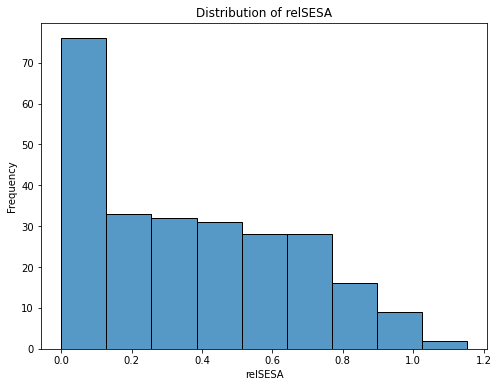

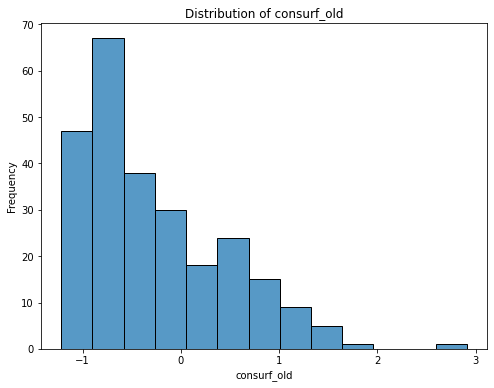

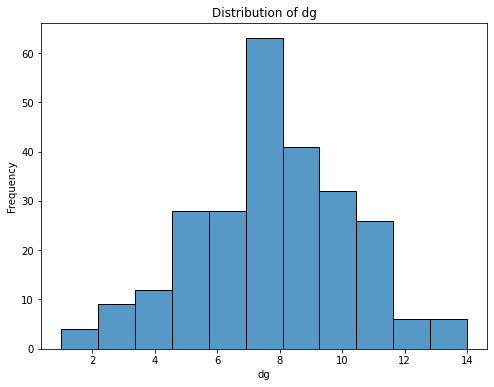

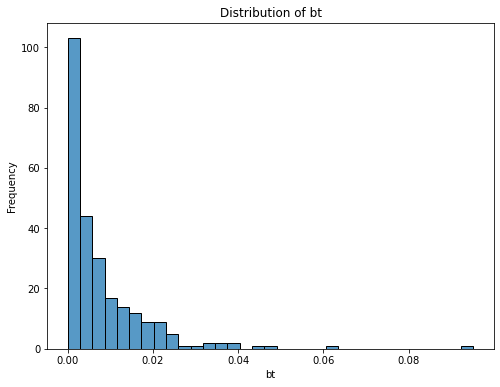

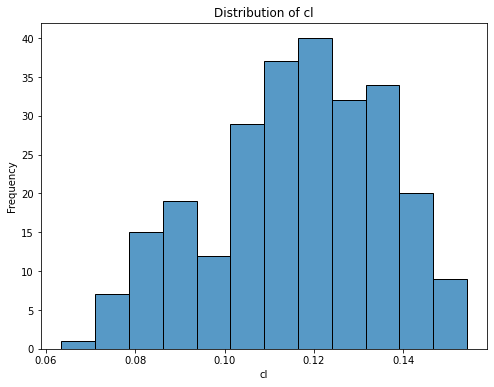

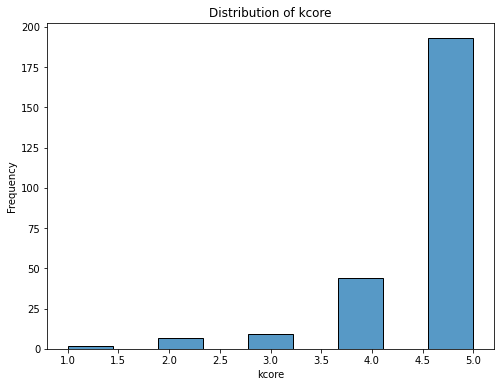

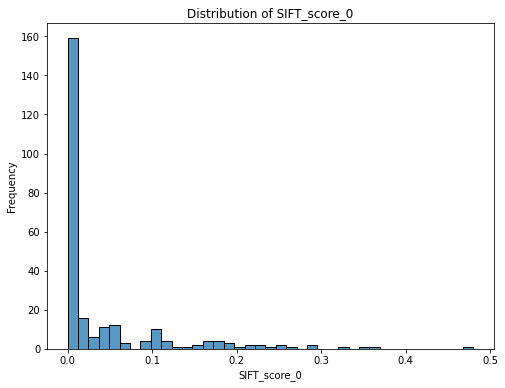

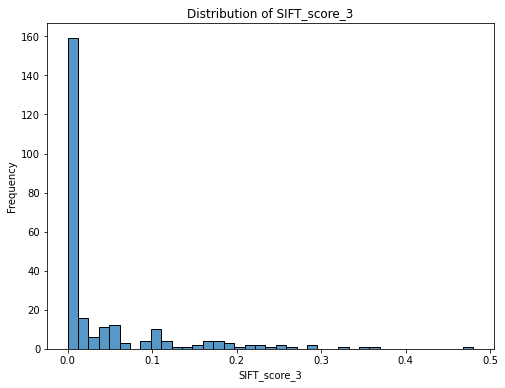

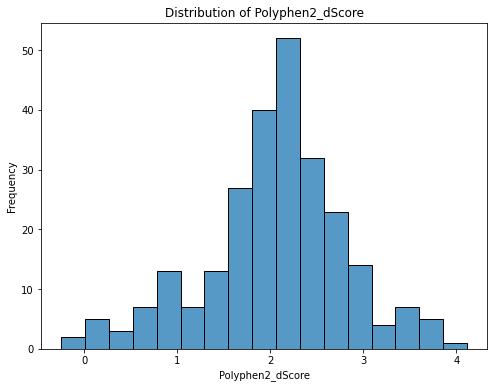

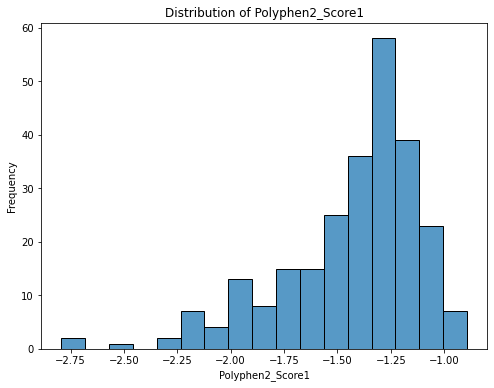

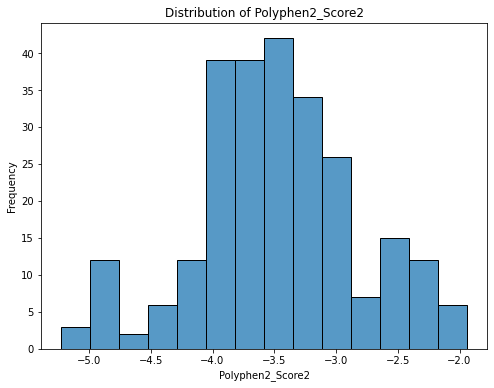

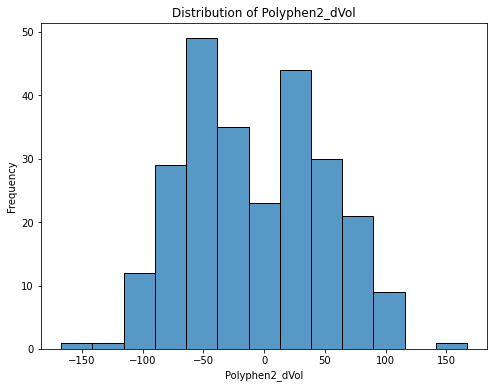

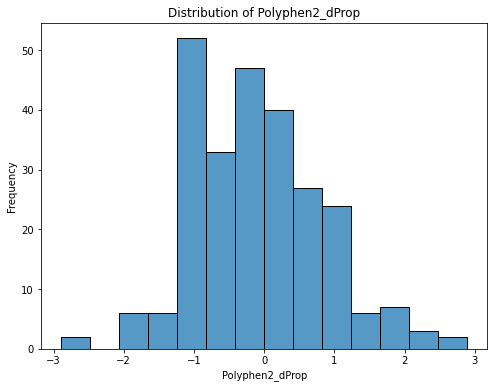

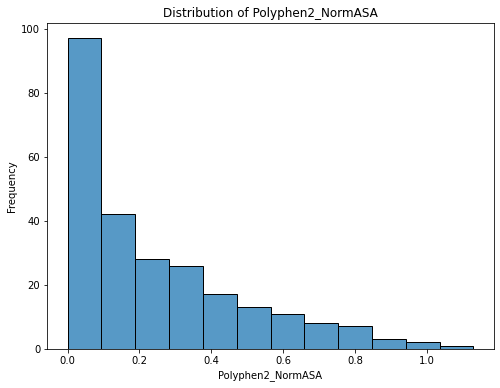

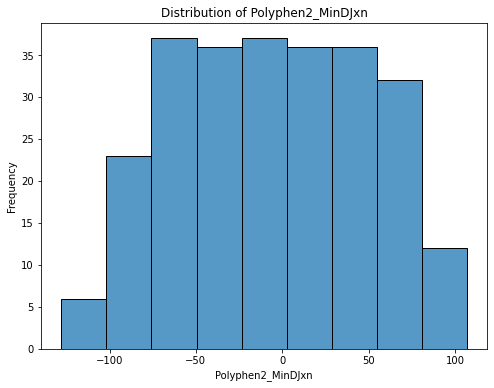

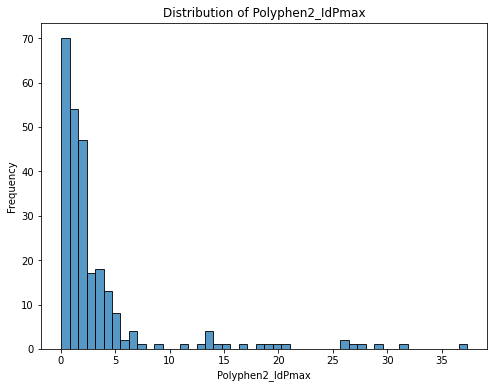

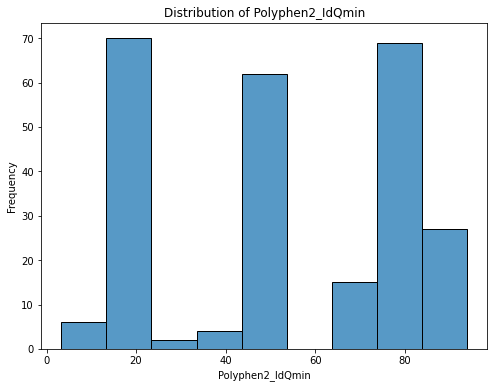

In [120]:
columns_to_normalize = ['relSESA', 'consurf_old', 'dg', 'bt', 'cl', 'kcore', 'SIFT_score_0',
                        'SIFT_score_3', 'Polyphen2_dScore', 'Polyphen2_Score1', 'Polyphen2_Score2',
                        'Polyphen2_dVol', 'Polyphen2_dProp', 'Polyphen2_NormASA', 'Polyphen2_MinDJxn',
                        'Polyphen2_IdPmax', 'Polyphen2_IdQmin']

for column in columns_to_normalize:
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(pat_attr[column], ax=ax)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")
    plt.show()

In [121]:


for column in columns_to_normalize:
    if pat_attr[column].skew() > 1:
        pat_attr[column] = np.log1p(pat_attr[column])

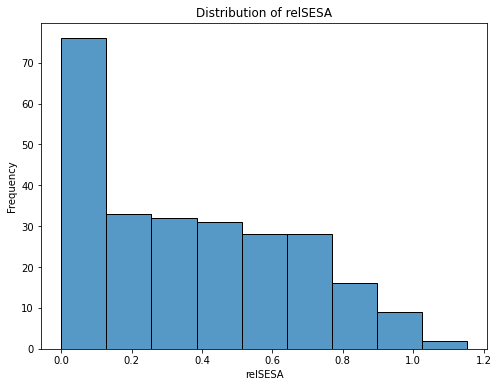

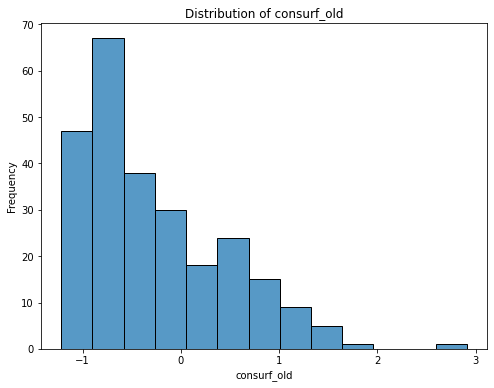

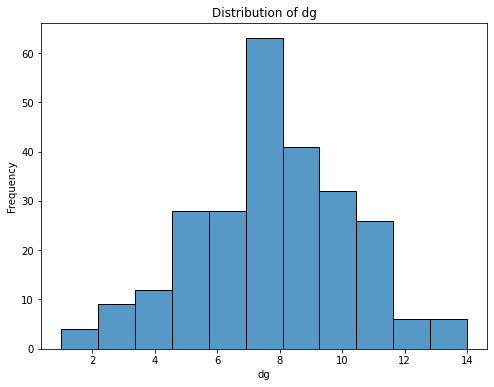

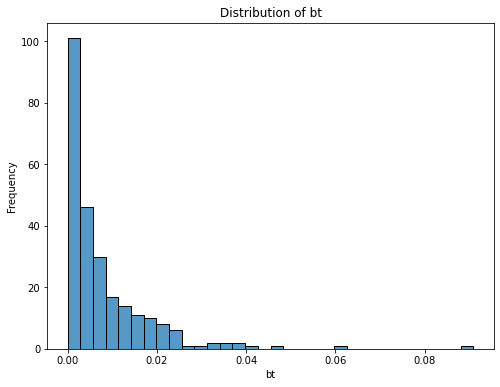

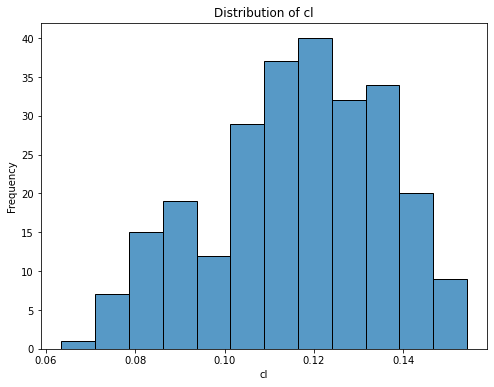

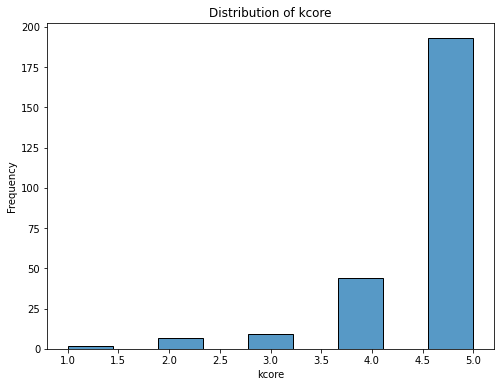

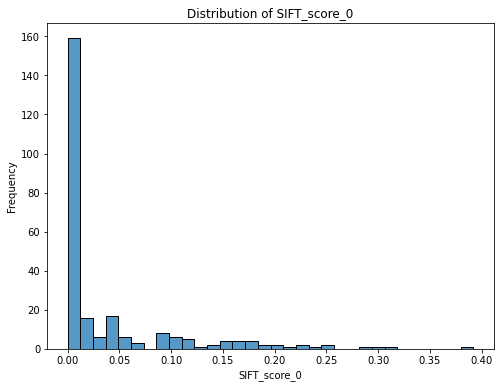

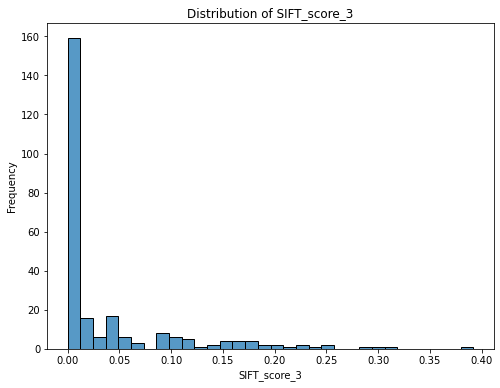

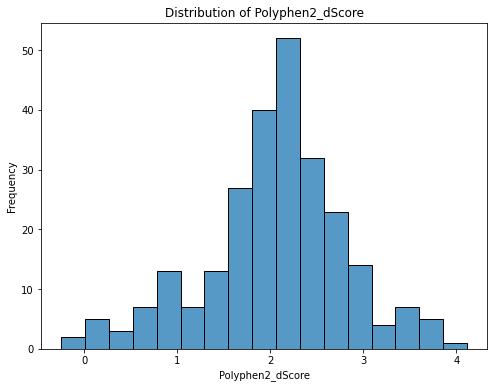

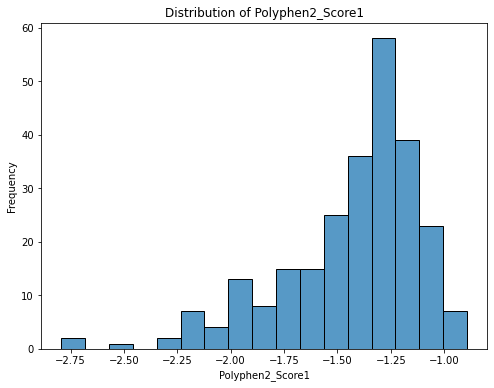

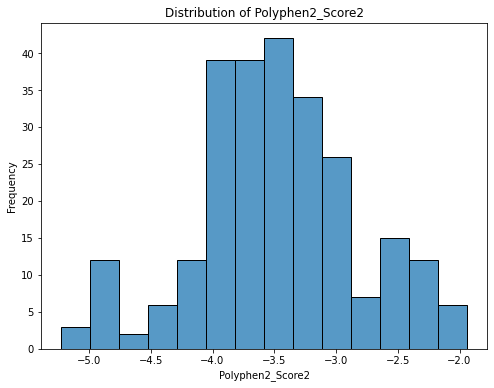

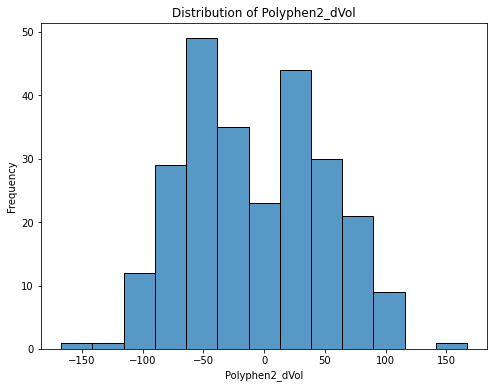

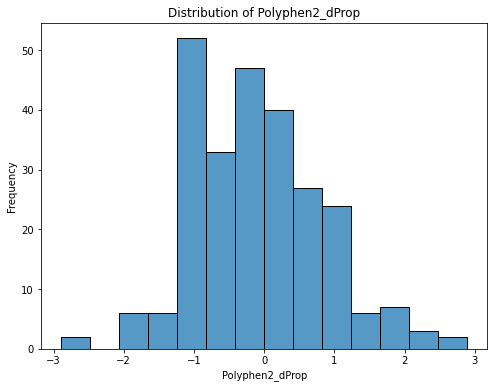

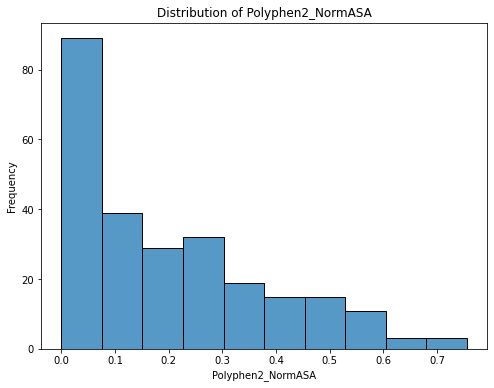

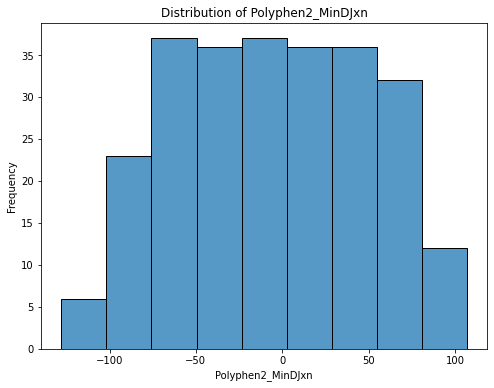

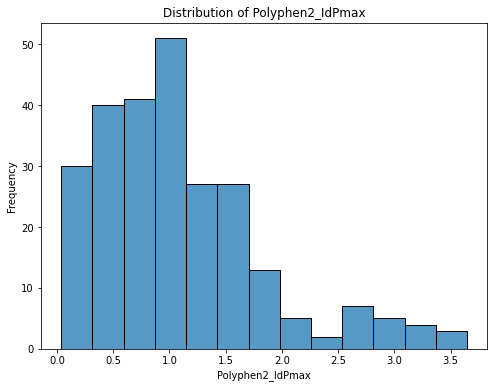

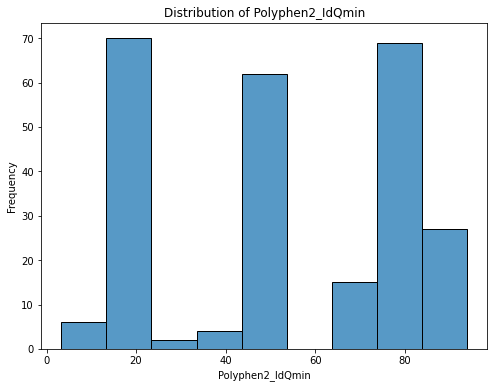

In [122]:

# Define a list of columns to plot
columns_to_plot = ['relSESA', 'consurf_old', 'dg', 'bt', 'cl', 'kcore', 'SIFT_score_0',
                   'SIFT_score_3', 'Polyphen2_dScore', 'Polyphen2_Score1', 'Polyphen2_Score2',
                   'Polyphen2_dVol', 'Polyphen2_dProp', 'Polyphen2_NormASA', 'Polyphen2_MinDJxn',
                   'Polyphen2_IdPmax', 'Polyphen2_IdQmin']

# Loop through the columns and plot the distribution
for column in columns_to_normalize:
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot the distribution using seaborn
    sns.histplot(pat_attr[column], ax=ax)
    # Set the title and labels
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")
    # Show the plot
    plt.show()


## Splitting the columns into dependent and independent variables 

In [123]:
X = pat_attr.drop("discrepancy", axis = 1).copy()
X.head()

,AA_HGVS,domain,relSESA,consurf_old,dg,bt,cl,auth,kcore,WT_aa,...,SIFT_score_3,Polyphen2_dScore,Polyphen2_Score1,Polyphen2_Score2,Polyphen2_dVol,Polyphen2_dProp,Polyphen2_NormASA,Polyphen2_MinDJxn,Polyphen2_IdPmax,Polyphen2_IdQmin
0,23,A1,0.822534,0.278,3.0,0.000731,0.111507,0.034230,2.0,R,...,0.019803,1.765,-1.459,-3.224,-113.0,0.91,0.489806,77.0,1.475449,77.24
3,29,A1,0.207992,-0.746,9.0,0.001464,0.112729,0.095604,5.0,V,...,0.000000,2.218,-1.236,-3.454,-80.0,-0.73,0.102557,58.0,1.063676,64.70
4,31,A1,0.250858,-0.134,7.0,0.006042,0.117071,0.074920,4.0,L,...,0.019803,2.502,-1.292,-3.794,-55.0,-1.07,0.294906,52.0,0.821540,46.96
6,41,A1,0.530462,0.853,5.0,0.000721,0.109411,0.025856,4.0,G,...,0.039221,2.905,-1.927,-4.832,48.0,0.75,0.401457,23.0,0.950499,87.07
7,48,A1,0.948756,0.614,3.0,0.008271,0.084397,0.000062,2.0,R,...,0.285179,1.450,-1.452,-2.902,-5.0,-1.14,0.523544,1.0,1.645963,77.24


In [124]:
y = pat_attr["discrepancy"].copy()
y.head()

0    0
3    0
4    0
6    1
7    1
Name: discrepancy, dtype: int32

In [125]:
y.unique()

array([0, 1])

## Creating one hot encoding

In [127]:
# Create an empty array to store the column names
obj_columns = []

# Loop through the columns of the dataframe
for col in X.columns:
    # Check if the column is an object
    if X[col].dtype == "object":
        # Save the column name to the array
        obj_columns.append(col)

# Print the array
print(obj_columns)

['domain', 'WT_aa', 'new_aa']


In [128]:
X_encoded = pd.get_dummies(X, columns= obj_columns)
X_encoded.head()

,AA_HGVS,relSESA,consurf_old,dg,bt,cl,auth,kcore,SIFT_score_0,SIFT_score_3,...,new_aa_M,new_aa_N,new_aa_P,new_aa_Q,new_aa_R,new_aa_S,new_aa_T,new_aa_V,new_aa_W,new_aa_Y
0,23,0.822534,0.278,3.0,0.000731,0.111507,0.034230,2.0,0.019803,0.019803,...,0,0,0,0,0,0,0,0,0,0
3,29,0.207992,-0.746,9.0,0.001464,0.112729,0.095604,5.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,31,0.250858,-0.134,7.0,0.006042,0.117071,0.074920,4.0,0.019803,0.019803,...,0,0,1,0,0,0,0,0,0,0
6,41,0.530462,0.853,5.0,0.000721,0.109411,0.025856,4.0,0.039221,0.039221,...,0,0,0,0,0,0,0,0,0,0
7,48,0.948756,0.614,3.0,0.008271,0.084397,0.000062,2.0,0.285179,0.285179,...,0,0,0,0,0,0,0,0,0,0


## Preliminary XGBOOST MODEL

In [129]:
sum(y)/len(y)

0.1607843137254902

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify= y)

In [131]:
sum(y_train)/len(y_train)

0.16230366492146597

In [132]:
sum(y_test) / len(y_test) 

0.15625

Confusion Matrix:
 [[49  5]
 [ 9  1]]


c:\Users\hajam\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


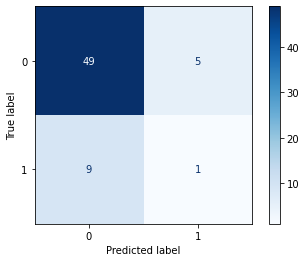

In [133]:

xgb_model = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = "auc", random_state = 42, n_estimators=200, max_depth=5, learning_rate=0.1)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plot_confusion_matrix(xgb_model, X_test, y_test, cmap = "Blues")

## Fine Tuning the model 

Best parameters: {'learning_rate': 0.027425083650459835, 'max_depth': 7, 'n_estimators': 199}
Best AUC score: 0.5788690476190477
Confusion Matrix:
 [[49  5]
 [ 9  1]]


c:\Users\hajam\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


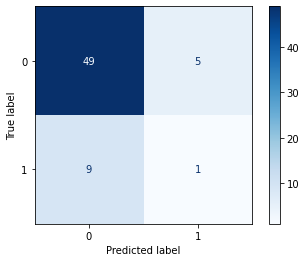

In [134]:

params = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3)
}

xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

xgb_search.fit(X_train, y_train)

print("Best parameters:", xgb_search.best_params_)
print("Best AUC score:", xgb_search.best_score_)

xgb_tuned = xgb_search.best_estimator_

y_pred_tuned = xgb_tuned.predict(X_test)

cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print("Confusion Matrix:\n", cm_tuned)

plot_confusion_matrix(xgb_tuned, X_test, y_test, cmap = "Blues")


In [135]:
bal_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
print("XGBoost Balanced Accuracy Score:", bal_acc_xgb)

XGBoost Balanced Accuracy Score: 0.46296296296296297


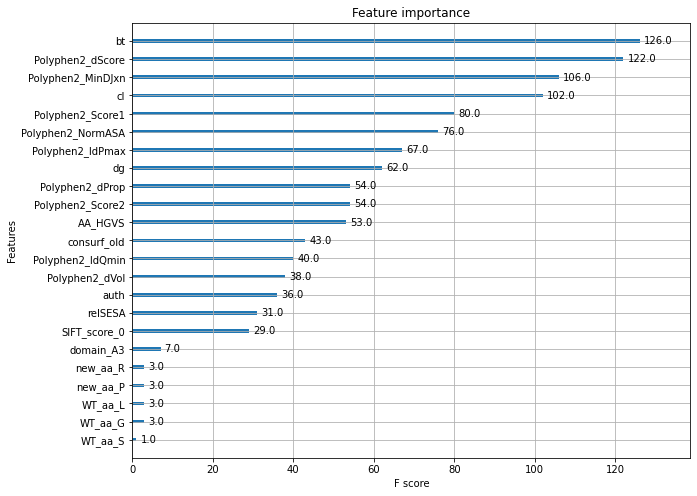

In [136]:
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_model, ax=ax)
plt.show()

## Creating a logistic regression model

In [137]:
lr_model = LogisticRegression(random_state=42)

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Predict the test set labels using the fitted model
y_pred_lr = lr_model.predict(X_test)

# Calculate and print the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Logistic Regression Confusion Matrix:\n", cm_lr)

# Calculate the balanced accuracy score and print it
bal_acc_lr = balanced_accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Balanced Accuracy Score:", bal_acc_lr)

Logistic Regression Confusion Matrix:
 [[53  1]
 [10  0]]
Logistic Regression Balanced Accuracy Score: 0.49074074074074076


c:\Users\hajam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
